# Preparations

In [2]:
import sys
import math
import copy
import itertools
import numpy as np

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number
from higgs_inference import settings


# Settings

In [3]:
# Doesn't do anything now except affect filenames
main_mode = 'vanilla'
#main_mode = 'histos'
#main_mode = 'aware'

# Interpolation in final plot.
interpolation_method = 'linear' #'linear'

# Which benchmark point to use
use_not_trained_benchmark = True

# More plots
neyman_plots = True
debug_plots = True

In [4]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

print(thetas[theta1])
print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/X_test.npy')

[0.39293227 0.43229216]
[-0.5 -0.5]


In [5]:
colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
bright_colors=['white', 'blue', 'black', '0.3']*2

scatter_alpha=0.5
linestyles = ['--', ':', '-.'] * 2

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Define strategies and load results

In [12]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [], [], []) # Usually, use four panels

expected_llr = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []

r_benchmark = []
p0_benchmark = []
p1 = []
scores_benchmark = []
r_roam = []

def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 neyman_suffix=None,
                 panel=-1, try_scores=True, is_truth=False, fix_exp=False):
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
        
        if fix_exp:
            _r_benchmark = np.exp(_r_benchmark)
            
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
    
    try:
        if neyman_suffix is None:
            _p_values = _load('neyman_pvalues_' + suffix, folder)
            _q_thresholds = _load('neyman_qcut_' + suffix, folder)
            _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + suffix, folder)
            _q_medians = _load('neyman_qmedian_' + suffix, folder)
        else:
            _p_values = _load('pvalues_' + neyman_suffix, folder)
            _q_thresholds = _load('neyman_qcut_' + neyman_suffix, folder)
            _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + neyman_suffix, folder)
            _q_medians = _load('neyman_qmedian_' + neyman_suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
        
    except IOError as err:
        print(err)
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
        
    except AssertionError as err:
        print(err)
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    try:
        _p1 = _load('p1_test', '../data/unweighted_events/')
        _p0_benchmark = _p1 * _r_benchmark
        do_densities = True
    except IOError:
        _p1 = None
        _p0_benchmark = None
        do_densities = False
    
    if try_scores:
        try:
            _scores_benchmark = _load('scores_' + benchmark_name + '_' + suffix, folder)
            do_scores = True
        except IOError:
            _scores_benchmark = None
            do_scores = False
    else:
        _scores_benchmark = None
        do_scores = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    
    r_benchmark.append(_r_benchmark)
    p1.append(_p1)
    p0_benchmark.append(_p0_benchmark)
    scores_benchmark.append(_scores_benchmark)
    r_roam.append(_r_roam)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 4:
        panel_indices[panel].append(index)
        
    if do_neyman or do_roaming or do_scores or do_densities:
        supported = []
        if do_neyman:
            supported.append('Neyman construction')
        if do_roaming:
            supported.append('x dependence plots')
        if do_scores:
            supported.append('score scatter plots')
        if do_densities:
            supported.append('densities')
        supported = ', '.join(supported)
            
        print('Loaded strategy ' + label + ' with support for ' + supported)
        
    else:
        print('Loaded strategy ' + label)
    

In [14]:
add_strategy('Truth', 'truth', 'truth', is_truth=True)

if main_mode == 'histos':
    add_strategy('$p_{T,j1}$ histogram', 'histo_ptj', 'histo', panel=0, try_scores=False)
    add_strategy('$\Delta \phi_{jj}$ histogram', 'histo_deltaphi', 'histo', panel=0, try_scores=False)
    
    add_strategy('2d histogram', 'histo_2d', 'histo', panel=1, try_scores=False)
    add_strategy('AFC', 'afc_5d_epsilon_0.50', 'afc', panel=1, try_scores=False)
    
    add_strategy('carl PbP raw', 'carl', 'point_by_point', panel=2, try_scores=False)
    add_strategy('regression PbP raw', 'regression', 'point_by_point', panel=2, try_scores=False)
    
    add_strategy('Ratio + score regr.', 'combinedregression_calibrated_alpha_100', 'parameterized', panel=3, try_scores=False)

if main_mode == 'aware':
    add_strategy('carl', 'carl_calibrated_aware_random', 'parameterized', panel=0, try_scores=False)
    add_strategy('Ratio regr.', 'regression_calibrated_aware_random', 'parameterized', panel=1, try_scores=False)
    add_strategy('carl + score regr.', 'combined_calibrated_aware_random', 'parameterized', panel=2, try_scores=False)
    add_strategy('Ratio + score regr.', 'combinedregression_calibrated_aware_random', 'parameterized', panel=3, try_scores=False)

else:
    add_strategy('Histogram', 'histo_2d_new', 'histo', panel=0, try_scores=False)
    add_strategy('carl', 'carl_calibrated_shallow_new', 'parameterized', panel=1, try_scores=False)
    
    add_strategy('Ratio regression', 'regression_calibrated_new', 'parameterized', panel=2, try_scores=False)
    add_strategy('Local score regr.', 'scoreregression_score_deep_new', 'score_regression', panel=2, try_scores=False)
    
    add_strategy('carl + score regr.', 'combined_calibrated_deep_new', 'parameterized', panel=3, try_scores=False)
    add_strategy('Ratio + score regr.', 'combinedregression_calibrated_deep_new', 'parameterized', panel=3, try_scores=False)

n_strategies = len(labels)

Loaded strategy Truth with support for Neyman construction, x dependence plots, score scatter plots, densities
Loaded strategy Histogram with support for Neyman construction, densities
Loaded strategy carl with support for Neyman construction, x dependence plots, densities
Loaded strategy Ratio regression with support for Neyman construction, x dependence plots, densities
Loaded strategy Local score regr. with support for Neyman construction, densities
Loaded strategy carl + score regr. with support for Neyman construction, x dependence plots, densities
Loaded strategy Ratio + score regr. with support for Neyman construction, x dependence plots, densities


# Interpolate LLR and p values

In [15]:
expected_llr_errors = [llr - expected_llr[truth_index] for llr in expected_llr]

In [16]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# interpolate
interpolated_p_values = []
interpolated_expected_llr = []
interpolated_expected_llr_mle = []

for p_vals, llr in zip(p_values, expected_llr):
    
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=True)
    if p_vals is not None:
        _p_vals, _ = interpolate(thetas, np.log(np.clip(p_vals,1.e-6, 1.)), xx, yy, method=interpolation_method)
        _p_vals = np.exp(_p_vals)
    else:
        _p_vals = None
    
    interpolated_p_values.append(_p_vals)
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)

In [17]:
if neyman_plots:
    # interpolate
    interpolated_q_medians = []
    interpolated_q_thresholds = []
    interpolated_95cl_excluded = []

    for qmed, qthresh, qthresh_err in zip(q_medians, q_thresholds, q_threshold_uncertainties):

        if qmed is None or qthresh is None or qthresh_err is None:
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_95cl_excluded.append(None)
            continue

        try:
            cut = (np.isfinite(qthresh)) & (np.isfinite(qmed)) & (np.isfinite(qthresh_err))
            _qthresh, _ = interpolate(thetas[cut], qthresh[cut], xx, yy, z_uncertainties_thetas=2*qthresh_err[cut],
                                      method='gp',
                                      length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                      matern_exponent=2.5,
                                      noise_level=0.01)
            _qmed, _ = interpolate(thetas[cut], qmed[cut], xx, yy,
                                      method='gp',
                                      length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                                      matern_exponent=2.5,
                                      noise_level=0.01)

            _excluded = _qmed - _qthresh

            interpolated_q_medians.append(_qmed)
            interpolated_q_thresholds.append(_qthresh)
            interpolated_95cl_excluded.append(_excluded)

        except ValueError as err:
            print(err)
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_95cl_excluded.append(None)

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.10942145e-05, -1.65712447e+01, -2.97069291e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 16, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.67968531e-05, -1.30978542e+02, -8.59999979e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 11, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.55333741e-04, -1.30364309e+02,  1.91775305e-04]), 'tas

# Likelihood ratio histograms

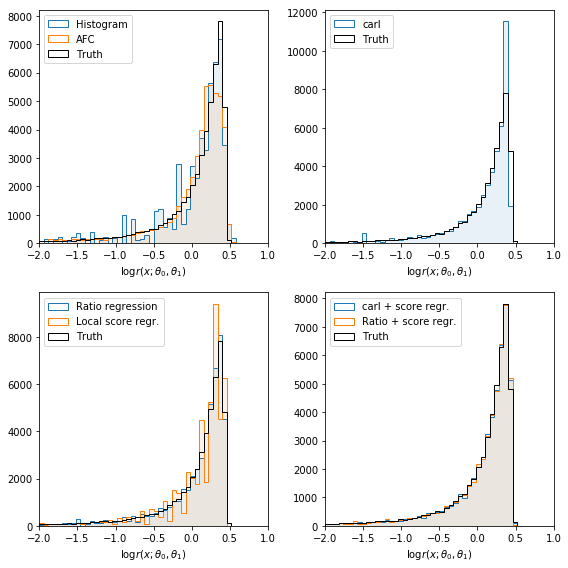

In [10]:
this_range = (-2.,1.)
this_bins  = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], alpha=0.1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], histtype='step',
                 label=labels[s])
        
    plt.hist(np.log(r_benchmark[truth_index]), range=this_range, bins=this_bins, color='black', histtype='step',
             label=labels[truth_index])
    
    plt.legend(loc='upper left')
    
    plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
    plt.xlim(this_range[0],this_range[1])

plt.tight_layout()
plt.savefig("../figures/results/r_histograms_" + main_mode + ".pdf")

# Benchmark theta: approximate vs exact r(x)

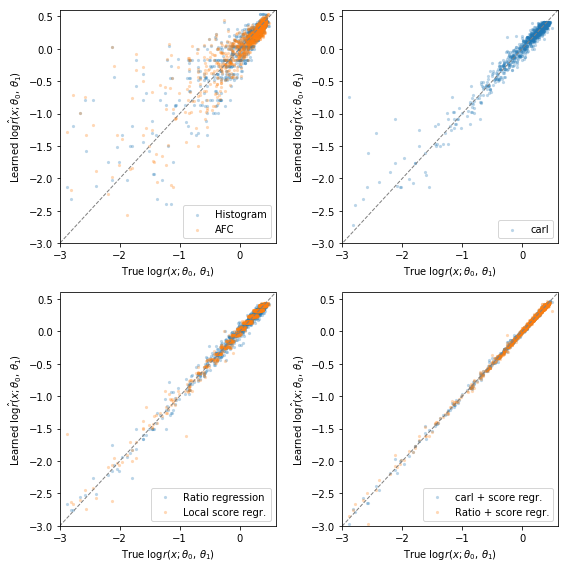

In [11]:
xmin = -3.
xmax = 0.6
skip = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=0.3, s=10., c=colors[i], lw=0.,
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
    plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")

plt.tight_layout()
plt.savefig("../figures/results/r_scatter_" + main_mode + ".pdf")

# Benchmark thetas: histograms of errors on log r

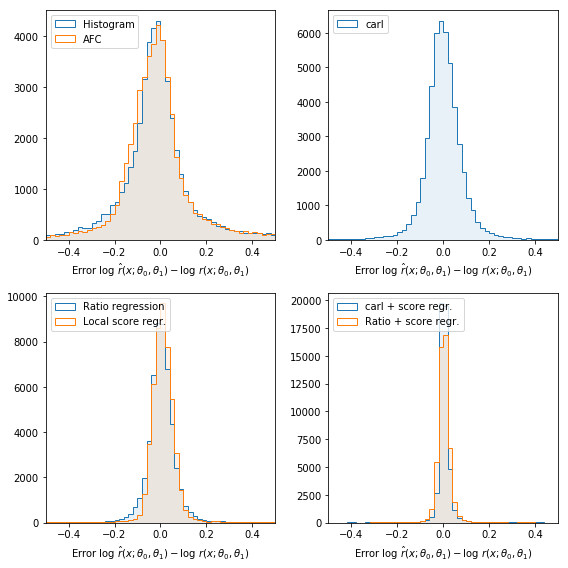

In [12]:
this_range = (-.5,.5)
this_bins  = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]) - np.log(r_benchmark[truth_index]),
                 range=this_range, bins=this_bins, color=colors[i], alpha=0.1)
        
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]) - np.log(r_benchmark[truth_index]),
                 range=this_range, bins=this_bins, color=colors[i], histtype='step',
                 label=labels[s])
        
    plt.legend(loc='upper left')
    plt.xlabel(r'Error $\log \ \hat{r}(x; \theta_0, \theta_1) - \log \ r(x; \theta_0, \theta_1)$')
    plt.xlim(this_range[0], this_range[1])
    
plt.tight_layout()
plt.savefig("../figures/results/r_error_histograms_" + main_mode + ".pdf")

# Benchmark theta: error on log r vs max(p0, p1)

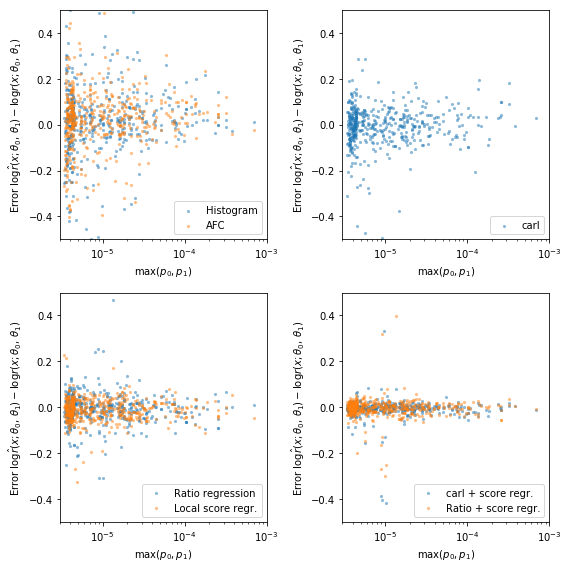

In [13]:
if debug_plots:
    xmin, xmax = -0.5, 0.5
    skip = 100

    fig = plt.figure(figsize=(8.,8.))

    for panel in range(4):

        ax = plt.subplot(2,2,panel+1)

        for i, s in enumerate(panel_indices[panel]):
            plt.scatter(np.maximum(p0_benchmark[truth_index], p1[truth_index])[::skip],
                        np.log(r_benchmark[truth_index][::skip]) - np.log(r_benchmark[s][::skip]),
                        marker='o', alpha=scatter_alpha, s=10., c=colors[i], lw=0.,
                        label=labels[s])

        plt.legend(loc='lower right')

        ax.set_xscale("log", nonposx='clip')
        plt.xlim(3.e-6,1.e-3)
        plt.ylim(xmin,xmax)

        plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
        plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")

    plt.tight_layout()
    plt.savefig("../figures/debug/r_error_vs_pmax_" + main_mode + ".pdf")

# MSE on log r over theta

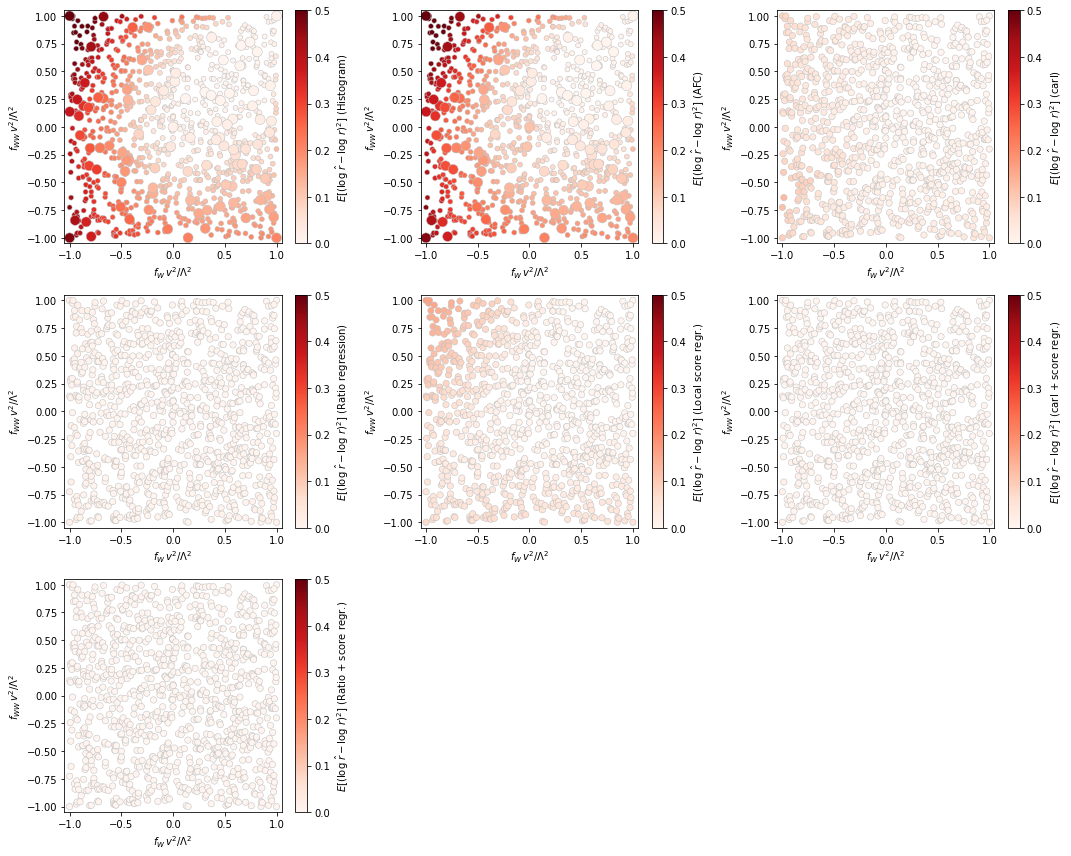

In [14]:
zmin, zmax = 0.,  0.5
colormap = 'Reds'

n_rows = math.ceil((len(labels) - 1) / 3.)

fig = plt.figure(figsize=(15.,n_rows*4.))

panel = 0 
for i, (label, err) in enumerate(zip(labels, mse_log_r)):
    if i == truth_index or err is None:
        continue
    panel += 1
        
    ax = plt.subplot(n_rows, 3, panel)
    
    if ('PbP' in label) or ('AFC' in label) or ('Histogram' in label):
        plt.scatter(thetas[::,0], thetas[::,1], c=err,
                    s=25.,
                    edgecolor='0.75', lw=0.5,
                    cmap=colormap,
                    vmin=zmin, vmax=zmax)
        plt.scatter(thetas[pbp_training_thetas,0], thetas[pbp_training_thetas,1], c=err[pbp_training_thetas],
                    s=100.,
                    edgecolor='0.75', lw=0.5,
                    cmap=colormap,
                    vmin=zmin, vmax=zmax)
    else:
        plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                    s=40.,
                    edgecolor='0.75', lw=0.5,
                    cmap=colormap,
                    vmin=zmin, vmax=zmax)
    
    if len(thetas_highlighted) > 0:
        plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1], c=err[thetas_highlighted],
                    s=150.,
                    edgecolor='0.75', lw=0.5,
                    cmap=colormap,
                    vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    
    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$E[(\log \ \hat{r} - \log \ r)^2]$ (' + label + ')')
    
plt.tight_layout()
plt.savefig("../figures/results/mse_log_r_over_theta_" + main_mode + ".pdf")

# Exact vs approximate expected log likelihood ratios

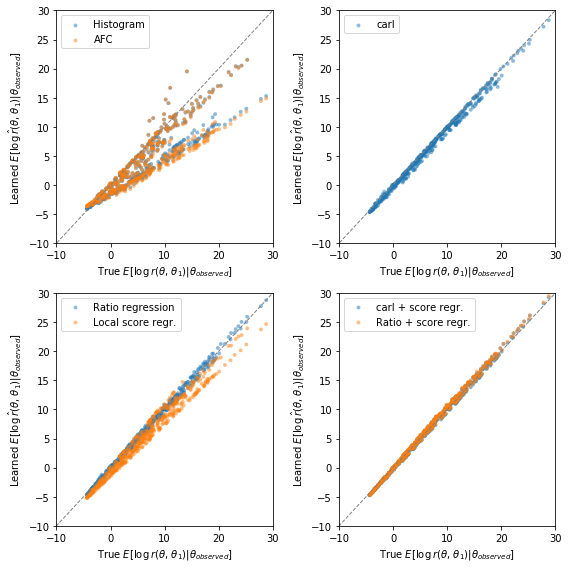

In [15]:
xmin, xmax = -10., 30.
skip = 2

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[i], alpha=scatter_alpha, 
                    s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::skip]],
                    lw=0.,
                    label=labels[s])
        
    plt.legend(loc='upper left')
    
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
    plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")

plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_scatter_" + main_mode + ".pdf")

# Error on log r expectation over theta

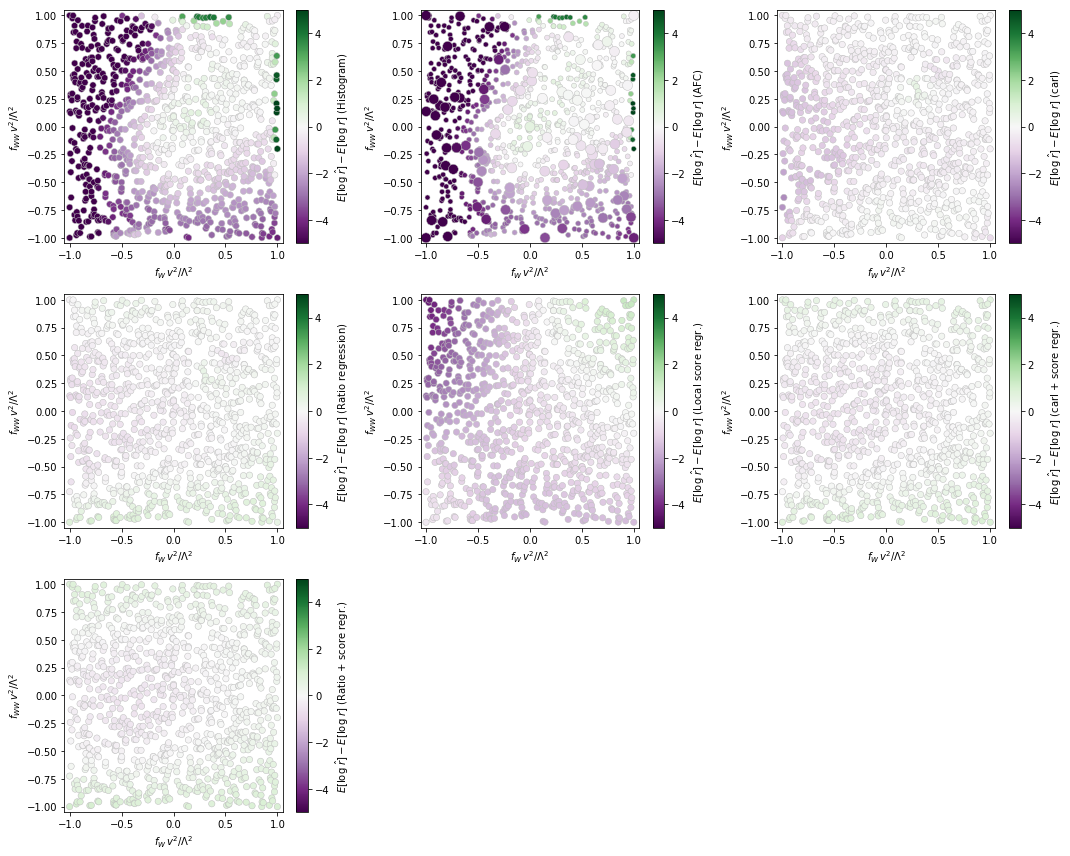

In [16]:
zmin, zmax = -5., 5.
n_rows = math.ceil((len(labels) - 1) / 3.)

fig = plt.figure(figsize=(15.,n_rows*4.))

panel = 0 
for i, (label, err) in enumerate(zip(labels, expected_llr_errors)):
    if i == truth_index:
        continue
    panel += 1
        
    ax = plt.subplot(n_rows, 3, panel)
    
    if ('PbP' in label) or ('AFC' in label):
        plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                    s=25.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
        plt.scatter(thetas[pbp_training_thetas,0], thetas[pbp_training_thetas,1], c=err[pbp_training_thetas],
                    s=100.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    else:
        plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                    s=40.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    
    if len(thetas_highlighted) > 0:
        plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1], c=err[thetas_highlighted],
                    s=150.,
                    edgecolor='0.75', lw=0.5,
                    cmap='PRGn',
                    vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    
    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$E[\log \ \hat{r}] - E[\log \ r]$ (' + label + ')')
    
plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_errors_over_theta_" + main_mode + ".pdf")

# Benchmark thetas: exact vs approximate score

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


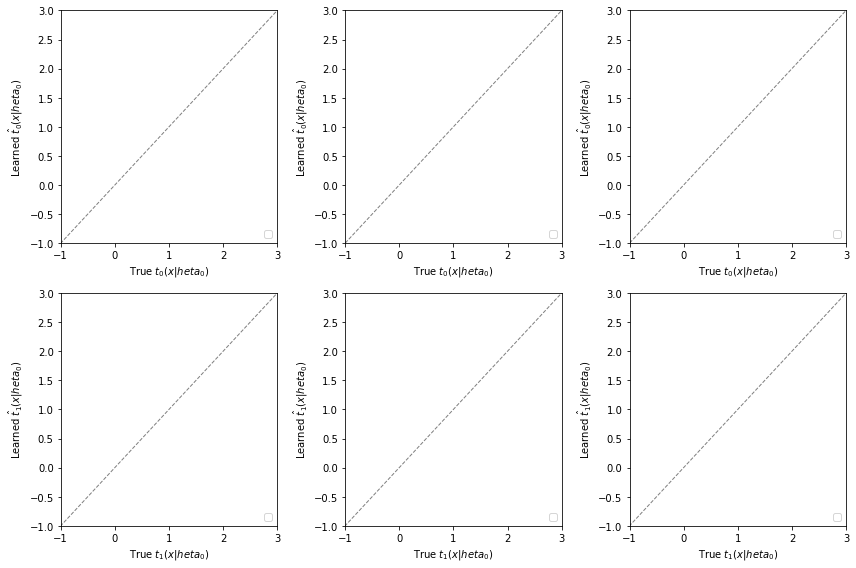

In [17]:
skip = 100
xmin, xmax = -1., 3.

fig = plt.figure(figsize=(12.,8.))

for actual_panel, panel in enumerate([0,1,3]):
        
    for component in range(2):
        ax = plt.subplot(2,3,actual_panel+1 + component*3)

        plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

        for i, s in enumerate(panel_indices[panel]):
            if scores_benchmark[s] is not None:
                plt.scatter(scores_benchmark[truth_index][::skip, component],
                            scores_benchmark[s][::skip, component],
                            marker='o', alpha=scatter_alpha, s=15., c=colors[i], lw=0.,
                            label=labels[s])

        plt.legend(loc='lower right')

        plt.xlim(xmin, xmax)
        plt.ylim(xmin, xmax)

        plt.xlabel(r"True $t_" + str(component) + "(x|\theta_0)$")
        plt.ylabel(r"Learned $\hat{t}_" + str(component) + "(x|\theta_0)$")

plt.tight_layout()
plt.savefig("../figures/results/score_scatter_" + main_mode + ".pdf")

# Theta dependence

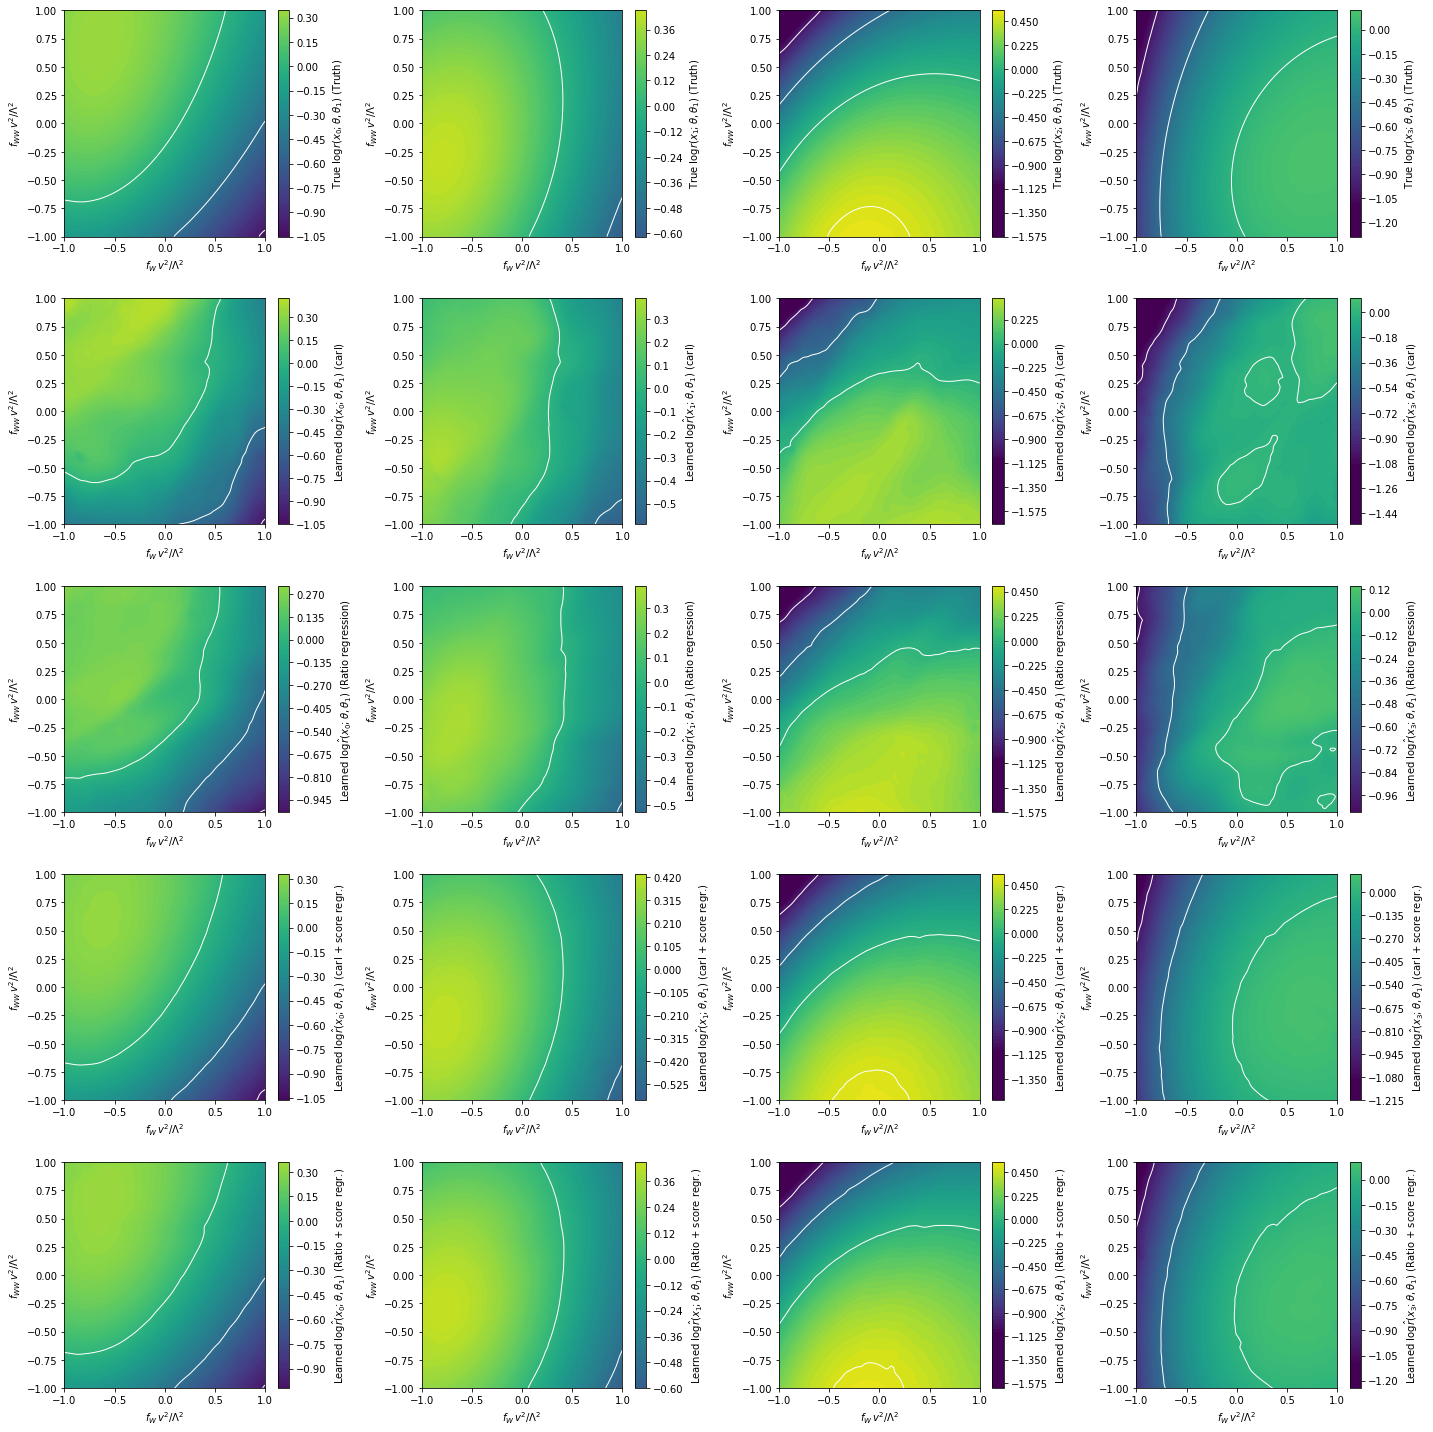

In [18]:
rmin, rmax = -1.1,0.6
r_lines = [-1.,-0.5,0.,0.5]

n_roaming = 10
show_roaming = [1,6,7,11]
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

n_strategies_shown = sum([r is not None for r in r_roam])

fig = plt.figure(figsize=(5.*n_roaming_show, 4.*n_strategies_shown))

i = 0
for s, (r, l) in enumerate(zip(r_roam, labels)):
    
    if r is None:
        continue
        
    for j in range(n_roaming_show):
        ax = plt.subplot(n_strategies_shown, n_roaming_show, 1 + n_roaming_show*i + j)
        
        #zi = np.clip(np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam))), rmin, rmax)
        zi = np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))

        cs = plt.contourf(xi, yi, zi,
                          100, cmap="viridis", vmin=rmin, vmax=rmax)
        cbar = plt.colorbar()
        plt.contour(xi, yi, zi,
                    r_lines,
                    linewidths=1., colors='white',
                    linestyles='solid')

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        if s == truth_index:
            cbar.set_label(r'True $\log r(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')
        else:
            cbar.set_label(r'Learned $\log \hat{r}(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')
        
    i += 1

plt.tight_layout()
plt.savefig("../figures/results/theta_dependence_comparison_" + main_mode + ".pdf")

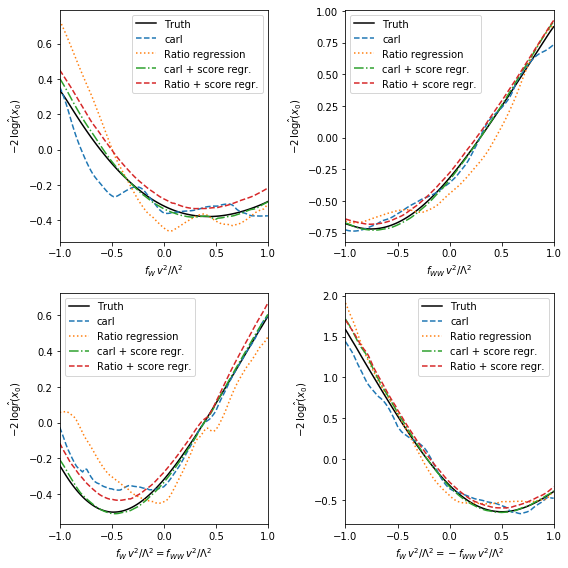

In [19]:
rmin, rmax = -1.1,0.6

show_roaming = [5]
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
zero_index = 50
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

fig = plt.figure(figsize=(4.*2, 4.*n_roaming_show*2))



for j in range(n_roaming_show):
    
    ax = plt.subplot(n_roaming_show*2, 2, j*4 + 1)
    
    yi_truth = -2. * np.log(r_roam[truth_index][show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))[:,zero_index]
    plt.plot(xi, yi_truth, c='black', label='Truth', ls='-')
    
    i = 0
    for s, (r, l) in enumerate(zip(r_roam, labels)):
        if r is None or s == truth_index:
            continue
        yi = -2. * np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))[:,zero_index]
        plt.plot(xi, yi, c=colors[i], label=l, ls=linestyles[i])
        i += 1
        
    plt.legend()

    plt.xlim(-1.0, 1.0)
    #plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$-2\, \log \hat{r}(x_" + str(j) + ")$")
    
    
    
    
    ax = plt.subplot(n_roaming_show*2, 2, j*4 + 2)
    
    yi_truth = -2. * np.log(r_roam[truth_index][show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))[zero_index,:]
    plt.plot(xi, yi_truth, c='black', label='Truth', ls='-')
    
    i = 0
    for s, (r, l) in enumerate(zip(r_roam, labels)):
        if r is None or s == truth_index:
            continue
        zi = np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))
        yi = -2. * zi[zero_index,:]
        plt.plot(xi, yi, c=colors[i], label=l, ls=linestyles[i])
        i += 1
        
    plt.legend()

    plt.xlim(-1.0, 1.0)
    #plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$-2\, \log \hat{r}(x_" + str(j) + ")$")
    
    
    
    ax = plt.subplot(n_roaming_show*2, 2, j*4 + 3)
    
    yi_truth = -2. * np.diag(np.log(r_roam[truth_index][show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam))))
    plt.plot(xi, yi_truth, c='black', label='Truth', ls='-')
    
    i = 0
    for s, (r, l) in enumerate(zip(r_roam, labels)):
        if r is None or s == truth_index:
            continue
        yi = -2. * np.diag(np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam))))
        plt.plot(xi, yi, c=colors[i], label=l, ls=linestyles[i])
        i += 1
        
    plt.legend()

    plt.xlim(-1.0, 1.0)
    #plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2 = f_{WW} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$-2\, \log \hat{r}(x_" + str(j) + ")$")
    
    
    
    
    ax = plt.subplot(n_roaming_show*2, 2, j*4 + 4)
    
    yi_truth = -2. * np.diag(np.log(r_roam[truth_index][show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))[:,::-1])
    plt.plot(xi, yi_truth, c='black', label='Truth', ls='-')
    
    i = 0
    for s, (r, l) in enumerate(zip(r_roam, labels)):
        if r is None or s == truth_index:
            continue
        yi = -2. * np.diag(np.log(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)))[:,::-1])
        plt.plot(xi, yi, c=colors[i], label=l, ls=linestyles[i])
        i += 1
        
    plt.legend()

    plt.xlim(-1.0, 1.0)
    #plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2 = - f_{WW} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$-2\, \log \hat{r}(x_" + str(j) + ")$")
    
    

plt.tight_layout()
plt.savefig("../figures/results/theta_dependence_1d_" + main_mode + ".pdf")

# Benchmark theta: x dependence

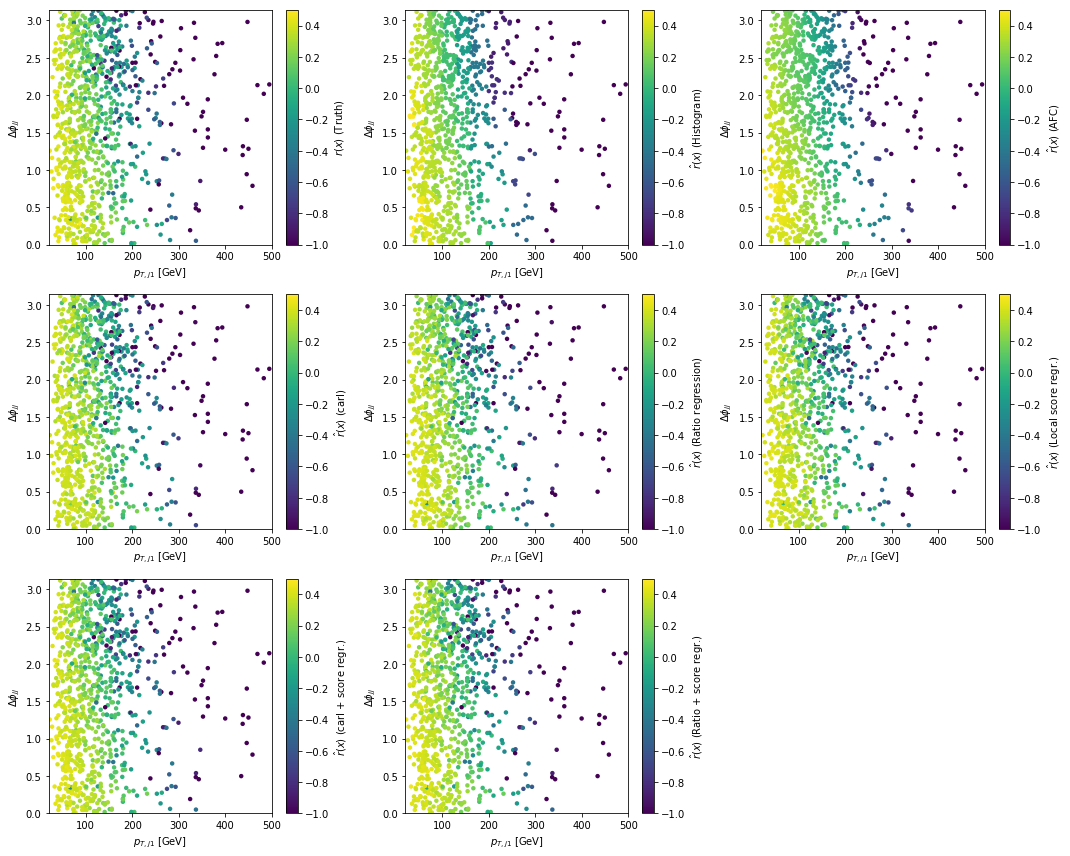

In [20]:
skip = 50

n_columns = math.ceil(len(r_benchmark) / 3.)

fig = plt.figure(figsize=(15.,4. * n_columns))

for i, (r, l) in enumerate(zip(r_benchmark, labels)):
    
    ax = plt.subplot(n_columns, 3, i + 1)

    plt.scatter(X_observed[::skip,1],
                X_observed[::skip,41],
                c=np.log(r[::skip]),
                vmin=-1., vmax=0.5,
                marker='o', s=20., lw=0.)
    cbar = plt.colorbar()
    
    plt.xlim(20.,500.)
    plt.ylim(0.,math.pi)
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    if i == truth_index:
        cbar.set_label(r'$r(x)$ (' + l + ')')
    else:
        cbar.set_label(r'$\hat{r}(x)$ (' + l + ')')

plt.tight_layout()
plt.savefig('../figures/results/x_dependence_' + main_mode + '.pdf')

# Expected LLR contours

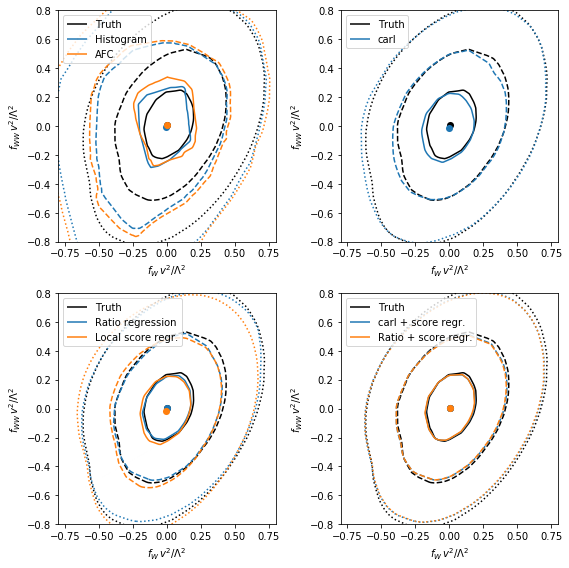

In [21]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

llr_lines = [1.,4.,9.]
llr_linestyles = ['solid','dashed','dotted']

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)

    cs = plt.contour(xi, yi, interpolated_expected_llr[truth_index], llr_lines,
                     linewidths=1.5, colors='black',
                     linestyles=llr_linestyles)
    cs.collections[0].set_label(labels[truth_index])
        
    for i, s in enumerate(panel_indices[panel]):
        cs = plt.contour(xi, yi, interpolated_expected_llr[s], llr_lines,
                         linewidths=1.5, colors=colors[i],
                         linestyles=llr_linestyles)
        cs.collections[0].set_label(labels[s])

    plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
                [yi[interpolated_expected_llr_mle[truth_index][0]]],
                marker='o', c='black', s=50, lw=0, zorder=10)
        
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[i], s=50, lw=0, zorder=10)

    plt.legend(loc='upper left')

    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results/likelihood_contours_" + main_mode + ".pdf")

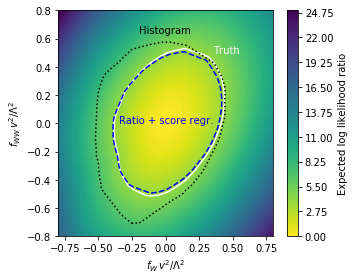

In [22]:
# Settings
strategies = [0,7,1]
llr_lines = [4.]
vmin, vmax = 0., 25.
label_pos = [(0.35,0.5),
              (-0.35,0.),
              (-0.2,0.64)]
linestyles_here = ['solid'] + linestyles

if main_mode == 'histos':
    strategies = [0,7,1,3]
    label_pos = [(0.45,0.35),
                  (-0.35,0.),
                  (0.19,0.71),
                  (-0.4,0.62)]

elif main_mode == 'aware':
    strategies = [0,1,2]
    label_pos = [(-0.25,0.2),
                  (-0.1,-0.15),
                  (-0.4,0.55)]
    

# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(5.,4.))

i = 0
for j, s in enumerate(strategies):
    if interpolated_expected_llr[s] is None:
        continue
        
    if i == 0:
        cs = plt.contourf(xi, yi, np.clip(interpolated_expected_llr[truth_index],vmin,vmax), 100, vmin=vmin,vmax=vmax, cmap='viridis_r')
        cbar = plt.colorbar()
        
    cs = plt.contour(xi, yi, interpolated_expected_llr[s], llr_lines,
                     linewidths=1.5, colors=bright_colors[i],
                     linestyles=linestyles_here[i])
    #plt.clabel(cs, cs.levels, inline=True, fontsize=12, fmt=lambda x: labels[s])
    
    plt.text(label_pos[j][0], label_pos[j][1], labels[s], color=bright_colors[i])
    
    #plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
    #            [yi[interpolated_expected_llr_mle[s][0]]],
    #            marker='o', c=bright_colors[i], s=50, lw=0, zorder=10)
    
    i+=1

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected log likelihood ratio')

plt.tight_layout()
plt.savefig("../figures/results/likelihood_contours_color_" + main_mode + ".pdf")

# Individual LLR outputs for debugging

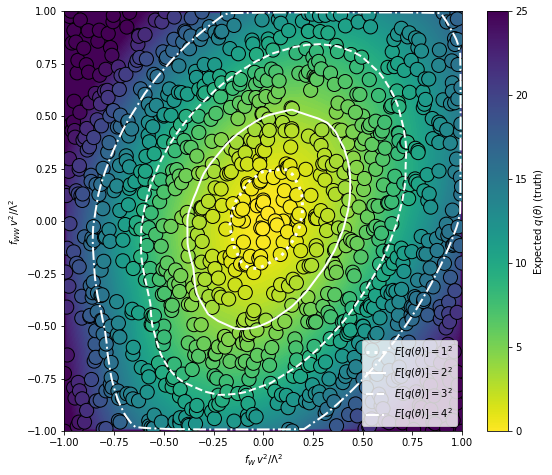

In [23]:
i = truth_index

plt.figure(figsize=(8.,6.7))

zi = np.clip(interpolated_expected_llr[i],0.,25.)

cs = plt.contourf(xi, yi, zi, 100, vmin=0.,vmax=25., cmap='viridis_r')

cs = plt.contour(xi, yi, zi, [1,4,9,16],
                 linewidths=[3.,2.,2.,2.], colors='w',
                 linestyles=['dotted', 'solid', 'dashed', '-.'])
cs.collections[0].set_label(r'$E[q(\theta)] = 1^2$')
cs.collections[1].set_label(r'$E[q(\theta)] = 2^2$')
cs.collections[2].set_label(r'$E[q(\theta)] = 3^2$')
cs.collections[3].set_label(r'$E[q(\theta)] = 4^2$')

plt.scatter(thetas[:,0], thetas[:,1],
            c=expected_llr[i] - min(expected_llr[i][:]),
            s=200., lw=1., cmap='viridis_r', edgecolors='k',
            vmin=0., vmax=25.)
cbar = plt.colorbar()

plt.legend(loc='lower right')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected $q(\theta)$ (truth)')

plt.tight_layout()
plt.savefig("../figures/debug/likelihood_contour_truth.pdf")

# CL contours from Neyman construction

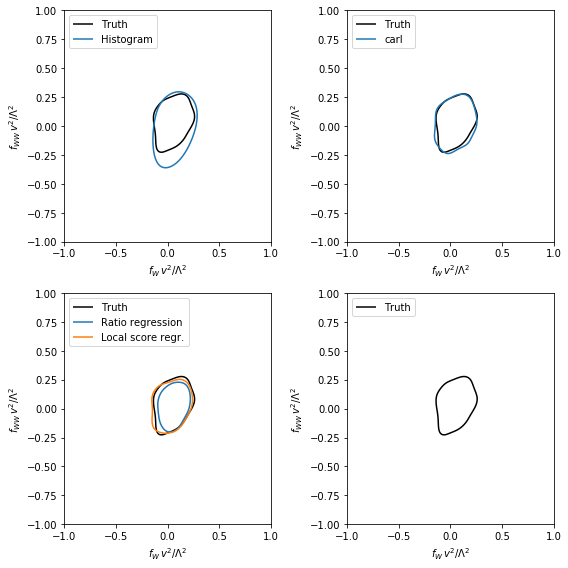

In [24]:
fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)

    cs = plt.contour(xi, yi, interpolated_95cl_excluded[truth_index], [0.],
                     linewidths=1.5, colors='black',
                     linestyles='solid')
    cs.collections[0].set_label(labels[truth_index])
        
    i = 0
    for s in panel_indices[panel]:
        if interpolated_p_values[s] is None:
            continue
        
        cs = plt.contour(xi, yi, interpolated_95cl_excluded[s], [0.],
                         linewidths=1.5, colors=colors[i],
                         linestyles='solid')
        cs.collections[0].set_label(labels[s])
        
        i += 1

    plt.legend(loc='upper left')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results/cl_contours_" + main_mode + ".pdf")

# Individual p-value plots for debugging

Truth


AttributeError: module 'higgs_inference.settings' has no attribute 'confidence_level'

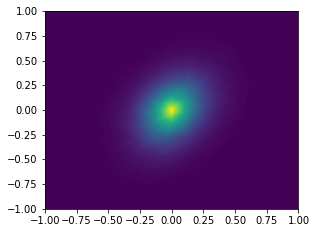

In [19]:
for i in range(n_strategies):
    if interpolated_p_values[i] is None:
        continue
        
    print(labels[i])
    
    plt.figure(figsize=(10,8))

    plt.subplot(2,2,1)
    zmin, zmax = 0.,0.5
    cs = plt.contourf(xi, yi, interpolated_p_values[i], 100, cmap='viridis',
                     vmin=zmin, vmax=zmax)
    cs = plt.contour(xi, yi, interpolated_p_values[i], [1.-settings.confidence_level],
                     linewidths=1.5, colors='w',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $68 \%$ CL contour (old)')
    plt.scatter(thetas[:,0], thetas[:,1],
                c=p_values[i],
                s=30., lw=0., cmap='viridis', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('Median $p$-value')

    plt.subplot(2,2,2)
    zmin, zmax = 0.,20.
    zi = np.clip(interpolated_q_medians[i],zmin,zmax)
    cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r',
                     vmin=zmin, vmax=zmax)
    plt.scatter(thetas[:,0], thetas[:,1],
                c=q_medians[i],
                s=30., lw=0., cmap='viridis_r', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    cs = plt.contour(xi, yi, zi, [settings.q_threshold],
                     linewidths=1.5, colors='w',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $68 \%$ CL contour (asymptotics)')
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('Median observed $q$')

    plt.subplot(2,2,3)
    zmin, zmax = settings.q_threshold - 2., settings.q_threshold + 2.
    zi = np.clip(interpolated_q_thresholds[i], zmin, zmax)
    cs = plt.contourf(xi, yi, zi, 100, cmap='PRGn',
                     vmin=zmin, vmax=zmax)
    plt.scatter(thetas[:,0], thetas[:,1],
                c=q_thresholds[i],
                s=30., lw=0., cmap='PRGn', edgecolors='k',
                vmin=zmin, vmax=zmax)
    cbar = plt.colorbar()
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('$q$ threshold for $68\%$ CL')

    plt.subplot(2,2,4)
    zmin, zmax = -5.,5.
    zi = np.clip(interpolated_95cl_excluded[i], zmin+0.01, zmax-0.01)
    cs = plt.contourf(xi, yi, zi, 100, cmap='PRGn',
                     vmin=zmin, vmax=zmax)
    cbar = plt.colorbar(cs)
    plt.contour(xi, yi, zi, [0.],
                     linewidths=1.5, colors='k',
                     linestyles='solid')
    cs.collections[0].set_label('Exp. $68 \%$ CL contour (new)')
    plt.legend(loc='lower right')
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label('$\Delta q$ (observed - threshold)')

    plt.tight_layout()
    plt.savefig("../figures/neyman/cl_contour_" + suffices[i] + ".pdf")